In [96]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas
import random

In [97]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


Epoch [10/100], Loss: 1.4313, Val Loss: 1.2607
Epoch [20/100], Loss: 1.1399, Val Loss: 1.0700
Epoch [30/100], Loss: 0.9847, Val Loss: 0.9350
Epoch [40/100], Loss: 0.7799, Val Loss: 0.7581
Epoch [50/100], Loss: 0.6421, Val Loss: 0.6400
Epoch [60/100], Loss: 0.5382, Val Loss: 0.5446
Epoch [70/100], Loss: 0.4566, Val Loss: 0.4682
Epoch [80/100], Loss: 0.4151, Val Loss: 0.4330
Epoch [90/100], Loss: 0.3937, Val Loss: 0.4170
Epoch [100/100], Loss: 0.3788, Val Loss: 0.4029


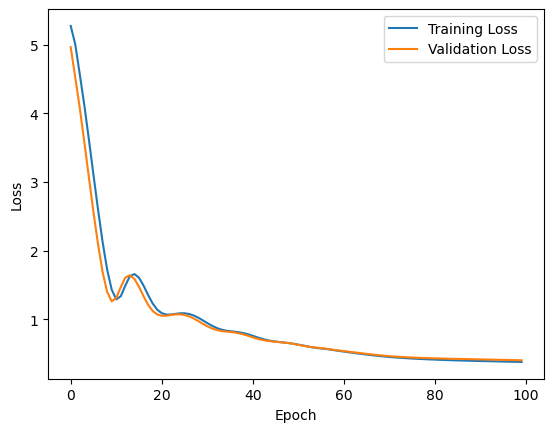

Test Loss: 0.3580


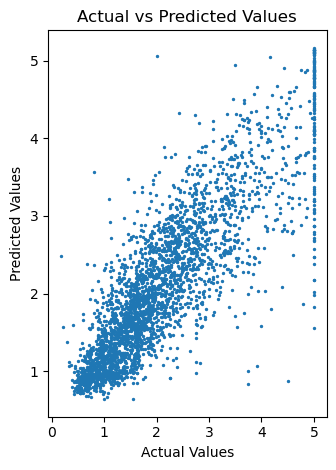

In [98]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the California housing dataset
data = fetch_california_housing()
X, y = data.data, data.target

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # Reshape to a column vector
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)  # Reshape to a column vector
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)  # Reshape to a column vector

# Define the neural network model
class HousingModel(nn.Module):
    def __init__(self, input_size ,fl=256,sl=128,tl=64, droprate=0.99):
        super(HousingModel, self).__init__()
        self.fc1 = nn.Linear(input_size, fl)
        self.relu1 = nn.ReLU()
        self.dropout= nn.Dropout(p=droprate)
        self.fc2 = nn.Linear(fl, sl)
        self.relu2 = nn.Sigmoid()
        self.fc3 = nn.Linear(sl, tl)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(tl, 1)            # Output layer

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.fc4(x)
        return x



# Instantiate the model
input_size = X_train.shape[1]
model = HousingModel(input_size,32,32,16,1)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Lists to store training and validation losses
train_losses = []
val_losses = []

# Training the model
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Evaluate on the validation set
    with torch.no_grad():
        model.eval()
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)
        val_losses.append(val_loss.item())

    train_losses.append(loss.item())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

# Plotting the training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model on the test set
with torch.no_grad():
    model.eval()
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')

    # Scatter plot for actual vs predicted values
    plt.subplot(1, 2, 2)
    plt.scatter(y_test, test_outputs, s=2,)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values')
plt.tight_layout()
plt.show()


In [99]:
import copy
import torch.nn as nn
import torch.nn.functional as F

def newlayer(layer, g):
    """Clone a layer and pass its parameters through the function g."""
    layer = copy.deepcopy(layer)
    if isinstance(layer, torch.nn.MaxPool2d):
      return layer
    else:
      layer.weight = torch.nn.Parameter(g(layer.weight))
      layer.bias = torch.nn.Parameter(g(layer.bias))
      return layer

In [100]:
class LRPDropout(nn.Module):
    def __init__(self,dropoutrate=0.5):
        super(LRPDropout, self).__init__()
        self.mask = None
        self.rate=dropoutrate

    def forward(self, x):
        if self.training:
            if self.mask is None:
              return x
            # During training, apply dropout
            # print(self.mask.shape,x.shape)
            output = x * self.mask / (1 - self.rate)
        else:
            # During evaluation, don't apply dropout
            output = x
        return output



    def update_mask(self, lrp_values, percentile=50):
        percentile=self.rate*100
        # calculate the threshold based on LRP values
        threshold = np.percentile((torch.abs(lrp_values).cpu().numpy()), percentile)

        # create a binary mask based on the threshold
        self.mask = (torch.abs(lrp_values) < threshold).float().to("cuda")
        # print(self.mask)

    def show_mask(self):
        print(self.mask)

In [105]:
# Define the neural network model
class HousingModellrp(nn.Module):
    def __init__(self, input_size ,fl=256,sl=128,tl=64, droprate=0.9):
        super(HousingModellrp, self).__init__()
        self.fc1 = nn.Linear(input_size, fl)
        self.relu1 = nn.ReLU()
        self.dropout1 = LRPDropout(droprate)
        self.fc2 = nn.Linear(fl, sl)
        self.relu2 = nn.ReLU()
        self.dropout2 = LRPDropout(droprate)
        self.fc3 = nn.Linear(sl, tl)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(tl, 1)            # Output layer

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        return x



# Instantiate the model
input_size = X_train.shape[1]
modellrp = HousingModellrp(input_size,32,32,16)

modellrp.cuda()
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(modellrp.parameters(), lr=0.01)

In [106]:


def LRP_individual(model, X, target, device):
    model.eval()
    # Get the list of layers of the network
    layers = [module for module in model.modules() if not isinstance(module, torch.nn.Sequential)][1:]
    # print(layers)
    # Propagate the input
    L = len(layers)
    A = [X] + [X] * L # Create a list to store the activation produced by each layer
    # print(layers)
    # print(len(A),layers)
    for layer in range(L):
        # print(A[layer].shape,layers[layer])
        # print(layers[layer])
        # if isinstance(layers[layer],torch.nn.Linear):
        #   # print(layers[layer])
        #   A[layer]=A[layer].reshape(-1,1,layers[layer].in_features)
        if isinstance(layers[layer], LRPDropout):
          # print(A[layer].shape)
          A[layer + 1] =A[layer]
        else:
          A[layer + 1] = layers[layer].forward(A[layer])

    # Get the relevance of the last layer using the highest classification score of the top layer
    T = A[-1].to(device)  # Remove .numpy().tolist()
    T = torch.abs(T) * 0
    # print(T)
    T = A[-1].clone()  # Use the actual output for relevance
    T = criterion(T, target)
    T = T.to(device)
    # Create the list of relevances with (L + 1) elements and assign the value of the last one
    R = [None] * L + [(A[-1] * T).data + 1e-6]
    # print("hi")
     # Propagation procedure from the top-layer towards the lower layers
    for layer in range(0, L)[::-1]:

        if isinstance(layers[layer], torch.nn.Conv2d) or isinstance(layers[layer], torch.nn.Conv3d) \
                or isinstance(layers[layer],torch.nn.Linear) or isinstance(layers[layer],torch.nn.MaxPool2d) :


            rho = lambda p: p

            A[layer] = A[layer].data.requires_grad_(True).to(device)

            # Step 1: Transform the weights of the layer and executes a forward pass
            z = newlayer(layers[layer], rho)

            z=z.forward(A[layer]) + 1e-9
            # print(layers[layer],z.shape,A[layer].shape)
            # print(z.shape,R[layer+1].shape,layers[layer],A[layer].shape)
            # Step 2: Element-wise division between the relevance of the next layer and the denominator
            # print(R[layer+1].shape, z.shape,layer+1)
            s = (R[layer+1] / z).data
            # print(s)
            # Step 3: Calculate the gradient and multiply it by the activation layer
            (z * s).sum().backward()
            c = A[layer].grad
            R[layer] = (A[layer] * c).cuda().data
            # R[layer] = R[layer + 1]
            # print(R)

        else:
            # print(layers[layer],"else")
            R[layer] = R[layer + 1]
        # if layer == 10:
        #             # print("hi")
        #             R[layer] = R[layer].reshape(-1,512,4,4)
    # Return the relevance of the all the layers
    model.train()
    return R

import numpy as np
# model.eval()
# print(train_loader.dataset.data[0:12].shape)
Rel = LRP_individual(modellrp, (X_test[0:4]).float().to("cuda"),y_test[0:4],device="cuda")
[print(tensor.shape,end="...") for tensor in Rel]


torch.Size([4, 8])...torch.Size([4, 32])...torch.Size([4, 32])...torch.Size([4, 32])...torch.Size([4, 32])...torch.Size([4, 32])...torch.Size([4, 32])...torch.Size([4, 16])...torch.Size([4, 16])...torch.Size([4, 1])...

[None, None, None, None, None, None, None, None, None, None]

Epoch [1/100], Loss: 6.1441, Val Loss: 5.6532
Epoch [2/100], Loss: 5.6933, Val Loss: 5.1873
Epoch [3/100], Loss: 5.2328, Val Loss: 4.6712
Epoch [4/100], Loss: 4.7271, Val Loss: 4.0552
Epoch [5/100], Loss: 4.1304, Val Loss: 3.3298
Epoch [6/100], Loss: 3.4390, Val Loss: 2.5592
Epoch [7/100], Loss: 2.7195, Val Loss: 1.8800
Epoch [8/100], Loss: 2.1098, Val Loss: 1.5135
Epoch [9/100], Loss: 1.8114, Val Loss: 1.5552
Epoch [10/100], Loss: 1.8705, Val Loss: 1.6277
Epoch [11/100], Loss: 1.8898, Val Loss: 1.4786
Epoch [12/100], Loss: 1.6580, Val Loss: 1.2126
Epoch [13/100], Loss: 1.3191, Val Loss: 0.9895
Epoch [14/100], Loss: 1.0444, Val Loss: 0.8768
Epoch [15/100], Loss: 0.8999, Val Loss: 0.8543
Epoch [16/100], Loss: 0.8597, Val Loss: 0.8726
Epoch [17/100], Loss: 0.8677, Val Loss: 0.8919
Epoch [18/100], Loss: 0.8804, Val Loss: 0.8928
Epoch [19/100], Loss: 0.8771, Val Loss: 0.8744
Epoch [20/100], Loss: 0.8561, Val Loss: 0.8474
Epoch [21/100], Loss: 0.8282, Val Loss: 0.8260
Epoch [22/100], Loss: 

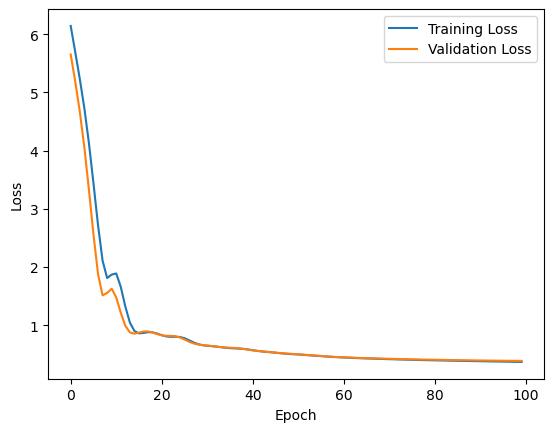

Test Loss: 0.3456


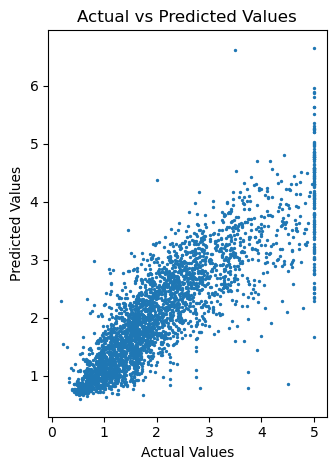

In [107]:
# Lists to store training and validation losses
train_losses = []
val_losses = []

# Training the model
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass
    if train_on_gpu:
            X_train,y_train=X_train.cuda(),y_train.cuda()
    outputs = modellrp(X_train)
    loss = criterion(outputs, y_train)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    Rel = LRP_individual(modellrp, X_train.float().to("cuda"),y_train,device="cuda")
    avg_tensor=torch.tensor([])
    for i in range(len(Rel)):
            if(len(avg_tensor)==0):
                avg_tensor=Rel
                for j in range(len(Rel)):
                    avg_tensor[j] += torch.mean(Rel[j], dim=0)
            avg_tensor[i] = torch.mean(Rel[i], dim=0)
            
            modellrp.dropout1.update_mask(avg_tensor[2])
            modellrp.dropout2.update_mask(avg_tensor[5])    
            
            
            
#     modellrp.dropout2.show_mask()       
    # Evaluate on the validation set
    with torch.no_grad():
        modellrp.eval()
        if train_on_gpu:
            X_val,y_val=X_val.cuda(),y_val.cuda()
        val_outputs = modellrp(X_val)
        val_loss = criterion(val_outputs, y_val)
        val_losses.append(val_loss.item())

    train_losses.append(loss.item())

    if (epoch + 1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

# Plotting the training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model on the test set
with torch.no_grad():
    modellrp.eval()
    if train_on_gpu:
            X_test,y_test=X_test.cuda(),y_test.cuda()
    test_outputs = modellrp(X_test)
    test_loss = criterion(test_outputs, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')

    # Scatter plot for actual vs predicted values
    plt.subplot(1, 2, 2)
    plt.scatter(y_test.cpu(), test_outputs.cpu(),s=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values')
plt.tight_layout()
plt.show()
